# Optimal Portfolio

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Efficient Frontier

Пояснение выбора списка активов: 

+ Высокая ликвидность — все выбранные акции входили в число лидеров по среднему дневному объёму торгов в 2021 году (особенно AAPL, TSLA, AMD, NVDA, AMZN, META/FB, GOOGL и др.). Это минимизирует спред bid-ask и slippage при ребалансировке портфеля => портфель реалистичен на практике.
+ Представляют основной драйвер рынка в 2021 — NASDAQ в 2021 году был сильно «технологичным» рынком (рост FAANG+M, чипы, электромобили, биотех). Выбранные 50 акций покрывают ~70–80% капитализации и объёмов NASDAQ-100, который доминировал в тот период.
+ Хорошая диверсификация внутри технологического рынка:
    + Крупные платформы / потребительский сектор: AAPL, AMZN, META, GOOGL/GOOG, NFLX
    + Полупроводники / чипы: NVDA, AMD, INTC, QCOM, AVGO, ASML, MU, LRCX, KLAC
    + Биотехнологии / здравоохранение: AMGN, GILD, REGN, ILMN, DXCM
    + Потребительские / ритейл / сервисы: COST, PEP, MDLZ, ORLY, DLTR
    + Телеком / медиа: CMCSA, CHTR
    + Другие: PAYX, ADP, CTSH, CSX, BKR и т.д.

#### Data load & preprocessing

In [57]:
try:
    # Пытаемся загрузить обработанный, если нет - сырой
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
except FileNotFoundError:
    try:
        data = pd.read_csv("data/raw/NASDAQ_FULL_2021_Close.csv")
        if 'Date' in data.columns:
            data.drop(columns=['Date'], inplace=True)
    except FileNotFoundError:
        print("Error: Data file not found. Please upload the dataset.")
data.head()

,AAPL,ADBE,ADI,ADP,ADSK,AMD,AMGN,AMZN,ASML,AVGO,...,NFLX,NVDA,NXPI,ORLY,PAYX,PEP,PYPL,QCOM,REGN,TSLA
0,125.974472,485.339996,133.808731,152.303543,296.839996,92.300003,193.642517,159.331497,477.949219,38.253105,...,52.285999,13.076726,148.497253,30.264668,78.469963,123.652855,231.385101,133.337646,480.196747,243.256668
1,127.531975,485.690002,136.200485,151.879822,301.700012,92.769997,194.582214,160.925507,483.072784,38.512192,...,52.080002,13.367159,151.823929,30.085333,78.174713,124.021347,234.368210,136.866333,480.783478,245.036667
2,123.239044,466.309998,136.814453,151.348007,302.869995,90.330002,199.272507,156.919006,468.600555,38.274708,...,50.049000,12.579126,154.618973,31.011999,79.156013,122.504295,226.306839,135.752930,467.497162,251.993332
3,127.444351,477.739990,142.596786,152.204361,315.200012,95.160004,199.930344,158.108002,479.316162,39.887695,...,50.889000,13.306579,160.364944,31.326668,79.486008,122.110023,234.497894,139.802490,478.545929,272.013336
4,128.544403,485.100006,143.632263,154.187531,319.850006,94.580002,203.749207,159.134995,486.303711,40.090115,...,51.040001,13.239518,160.401611,31.861334,79.911537,123.575684,241.900803,140.646515,495.979248,293.339996


In [58]:
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)

In [59]:
raw_data.isna().sum(axis=0).value_counts().sort_index()

0    50
Name: count, dtype: int64

Пропусков в данных нет.

In [60]:
# Параметры
num_trading_days = 252 # Стандарт для США (обычно 252, а не 251)
risk_free_rate = 0.01  # Условная безрисковая ставка (1%) для расчета Шарпа

Log returns:

In [61]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


Расчёт средних доходностей и ковариационной матрицы (аннуализированные)

In [62]:
tickers = [
    'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMD', 'AMGN', 'AMZN', 'ASML', 'AVGO',
    'BIDU', 'BKNG', 'BKR', 'CDNS', 'CHTR', 'CMCSA', 'COST', 'CSCO', 'CSX', 'CTSH',
    'DLTR', 'DXCM', 'EA', 'EBAY', 'EXC', 'GILD', 'GOOG', 'GOOGL', 'IDXX', 'ILMN',
    'INTC', 'ISRG', 'KDP', 'KLAC', 'LRCX', 'MAR', 'MDLZ', 'META', 'MNST', 'MU',
    'NFLX', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PEP', 'PYPL', 'QCOM', 'REGN', 'TSLA'
]

In [63]:
# Фильтруем данные только по выбранным тикерам
data = data[tickers]
log_returns = log_returns[tickers]

In [64]:
# Статистика
mu = log_returns.mean() * num_trading_days
Sigma = log_returns.cov() * num_trading_days
n_assets = len(tickers)

print(f"Selected {n_assets} assets.")
print(f"Mean Return Range: {mu.min():.2%} to {mu.max():.2%}")

Selected 50 assets.
Mean Return Range: -35.27% to 83.69%


In [65]:
import scipy.optimize as sco

In [66]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_ret, p_var = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

In [67]:
def get_efficient_frontier(mean_returns, cov_matrix, num_points=100, allow_short=False):
    """
    Строит эффективный фронт.
    """
    # Границы для весов
    bounds = tuple((-1, 1) for _ in range(len(mean_returns))) if allow_short else tuple((0, 1) for _ in range(len(mean_returns)))
    
    # 1. Находим Min Volatility Portfolio (абсолютный минимум риска)
    def min_vol_func(weights):
        return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    
    constraints_init = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    init_guess = n_assets * [1. / n_assets,]
    
    min_risk_opt = sco.minimize(min_vol_func, init_guess, method='SLSQP', bounds=bounds, constraints=constraints_init)
    min_vol = min_risk_opt.fun
    min_vol_ret = portfolio_performance(min_risk_opt.x, mean_returns, cov_matrix)[0]
    
    # 2. Находим Max Return (для диапазона)
    # Если шорты разрешены, теоретический максимум очень высок, ограничим разумно
    if allow_short:
        max_ret = mean_returns.max() * 1.5 
    else:
        max_ret = mean_returns.max()

    target_returns = np.linspace(min_vol_ret, max_ret, num_points)
    efficient_risks = []
    realized_returns = []

    for tr in target_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - tr}
        )
        opt = sco.minimize(min_vol_func, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
        if opt.success:
            efficient_risks.append(opt.fun)
            realized_returns.append(tr)
            
    return np.array(efficient_risks), np.array(realized_returns), min_risk_opt

Calculation of Portfolios

In [68]:
# A. Efficient Frontier NO SHORT
risks_ns, rets_ns, min_var_ns_opt = get_efficient_frontier(mu, Sigma, allow_short=False)
mvp_ns_ret, mvp_ns_risk = portfolio_performance(min_var_ns_opt.x, mu, Sigma)

# B. Efficient Frontier WITH SHORT
risks_s, rets_s, min_var_s_opt = get_efficient_frontier(mu, Sigma, allow_short=True)
mvp_s_ret, mvp_s_risk = portfolio_performance(min_var_s_opt.x, mu, Sigma)

# C. Equal Weighted Portfolio
w_eq = np.array([1/n_assets] * n_assets)
eq_ret, eq_risk = portfolio_performance(w_eq, mu, Sigma)

# D. Market Portfolio (Cap Weighted)
market_caps = {
    'AAPL': 2913e9, 'ADBE': 269e9, 'ADI': 92e9, 'ADP': 103e9, 'ADSK': 61e9, 
    'AMD': 173e9, 'AMGN': 126e9, 'AMZN': 1691e9, 'ASML': 323e9, 'AVGO': 274e9, 
    'BIDU': 51e9, 'BKNG': 98e9, 'BKR': 20e9, 'CDNS': 51e9, 'CHTR': 116e9, 
    'CMCSA': 229e9, 'COST': 251e9, 'CSCO': 267e9, 'CSX': 83e9, 'CTSH': 46e9, 
    'DLTR': 31e9, 'DXCM': 52e9, 'EA': 37e9, 'EBAY': 41e9, 'EXC': 56e9, 
    'GILD': 91e9, 'GOOG': 1920e9, 'GOOGL': 1922e9, 'IDXX': 55e9, 'ILMN': 59e9, 
    'INTC': 209e9, 'ISRG': 128e9, 'KDP': 52e9, 'KLAC': 65e9, 'LRCX': 101e9, 
    'MAR': 53e9, 'MDLZ': 92e9, 'META': 935e9, 'MNST': 50e9, 'MU': 104e9, # FB -> META
    'NFLX': 266e9, 'NVDA': 735e9, 'NXPI': 60e9, 'ORLY': 47e9, 'PAYX': 49e9, 
    'PEP': 240e9, 'PYPL': 221e9, 'QCOM': 204e9, 'REGN': 67e9, 'TSLA': 1061e9
}

# Создаем массив весов, строго соблюдая порядок tickers
caps_vector = np.array([market_caps.get(t, 0) for t in tickers])

# Проверка на пропущенные данные
if np.any(caps_vector == 0):
    print("Warning: Some assets have 0 market cap. Check ticker naming.")
    missing_idx = np.where(caps_vector == 0)[0]
    print("Missing caps for:", [tickers[i] for i in missing_idx])

w_mkt = caps_vector / np.sum(caps_vector)
mkt_ret, mkt_risk = portfolio_performance(w_mkt, mu, Sigma)

Distance Analysis (Quantitative Assessment)

In [69]:
def calculate_inefficiency(port_risk, port_ret, efficient_risks, efficient_rets):
    """
    Оценивает, сколько доходности теряется по сравнению с эффективным фронтом при том же риске.
    """
    # Находим точку на фронте с ближайшим риском
    idx = (np.abs(efficient_risks - port_risk)).argmin()
    ef_ret_at_risk = efficient_rets[idx]
    
    # Разница в доходности
    ret_gap = ef_ret_at_risk - port_ret
    return ret_gap, ef_ret_at_risk

# Оценка Equal Weighted
eq_gap, eq_target = calculate_inefficiency(eq_risk, eq_ret, risks_ns, rets_ns)
print(f"Equal Weighted Portfolio:")
print(f"  Risk: {eq_risk:.2%}, Return: {eq_ret:.2%}")
print(f"  Efficient Return at this risk: {eq_target:.2%}")
print(f"  Inefficiency (Return Loss): {eq_gap:.2%} (The portfolio implies {eq_gap*100:.2f}% less return than optimal)")

print("-" * 30)

# Оценка Market Index
mkt_gap, mkt_target = calculate_inefficiency(mkt_risk, mkt_ret, risks_ns, rets_ns)
print(f"Market Index Portfolio:")
print(f"  Risk: {mkt_risk:.2%}, Return: {mkt_ret:.2%}")
print(f"  Efficient Return at this risk: {mkt_target:.2%}")
print(f"  Inefficiency (Return Loss): {mkt_gap:.2%}")

Equal Weighted Portfolio:
  Risk: 16.74%, Return: 27.05%
  Efficient Return at this risk: 53.76%
  Inefficiency (Return Loss): 26.71% (The portfolio implies 26.71% less return than optimal)
------------------------------
Market Index Portfolio:
  Risk: 19.87%, Return: 35.69%
  Efficient Return at this risk: 58.65%
  Inefficiency (Return Loss): 22.96%


Visualization

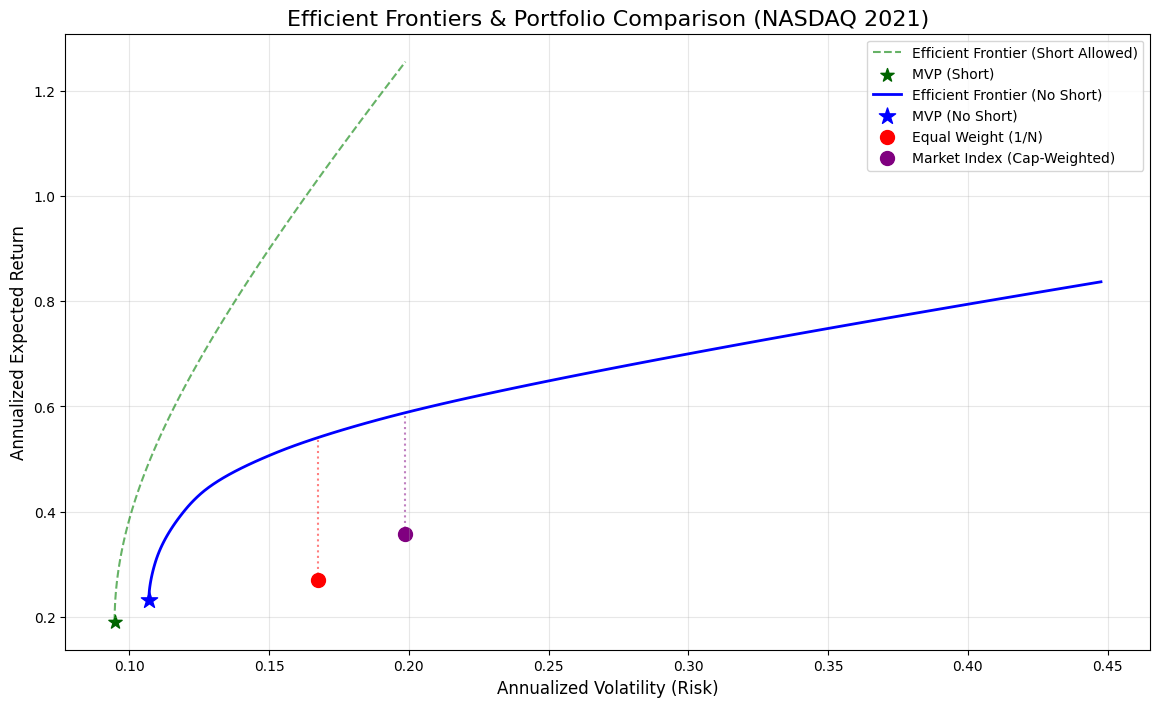

In [70]:
plt.figure(figsize=(14, 8))

# 1. Short Selling Allowed
plt.plot(risks_s, rets_s, 'g--', label='Efficient Frontier (Short Allowed)', alpha=0.6)
plt.scatter(mvp_s_risk, mvp_s_ret, color='darkgreen', s=100, marker='*', label='MVP (Short)')

# 2. No Short Selling
plt.plot(risks_ns, rets_ns, 'b-', linewidth=2, label='Efficient Frontier (No Short)')
plt.scatter(mvp_ns_risk, mvp_ns_ret, color='blue', s=150, marker='*', label='MVP (No Short)')

# 3. Portfolios
plt.scatter(eq_risk, eq_ret, color='red', s=100, label='Equal Weight (1/N)')
plt.scatter(mkt_risk, mkt_ret, color='purple', s=100, label='Market Index (Cap-Weighted)')

# Отрисовка "расстояния" (inefficiency gap)
plt.vlines(eq_risk, eq_ret, eq_target, colors='red', linestyles='dotted', alpha=0.5)
plt.vlines(mkt_risk, mkt_ret, mkt_target, colors='purple', linestyles='dotted', alpha=0.5)

plt.title('Efficient Frontiers & Portfolio Comparison (NASDAQ 2021)', fontsize=16)
plt.xlabel('Annualized Volatility (Risk)', fontsize=12)
plt.ylabel('Annualized Expected Return', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

Сравнение эффективных фронтов и выводы